<a href="https://colab.research.google.com/github/wesley0521/kaggle/blob/main/Kaggle-titanic%20survived%20predict-RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
train = pd.read_csv("/content/train-titanic.csv")
test = pd.read_csv("/content/test-titanic.csv")
train.reset_index(inplace=True,drop=True)
data = pd.concat([train,test],ignore_index=True)
data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
#印出資料的資訊查看是否有空值
data.info()
#發現有些欄位有空值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [ ]:
#先將Name欄位進行處理
data["Name"].head(5)

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"


In [ ]:
#發現名字的第二個位置為特殊稱謂因此提取出來
data["Name"] = data["Name"].str.split(", ",expand=True)[1]
data["Name"] = data["Name"].str.split(".",expand=True)[0]
#創立一個名字稱謂的字典
name_dict = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}
#將提取出來的稱謂漢字典結合
data["Name"] = data["Name"].map(name_dict)
#將稱謂轉換成數字
data["Name"] = data["Name"].astype("category").cat.codes
data["Name"].head(5)

,Name
0,2
1,3
2,1
3,3
4,2


In [ ]:
#建立一個FamilySize的欄位為SibSp和Parch加總
data["FamilySize"] = data["SibSp"] + data["Parch"]

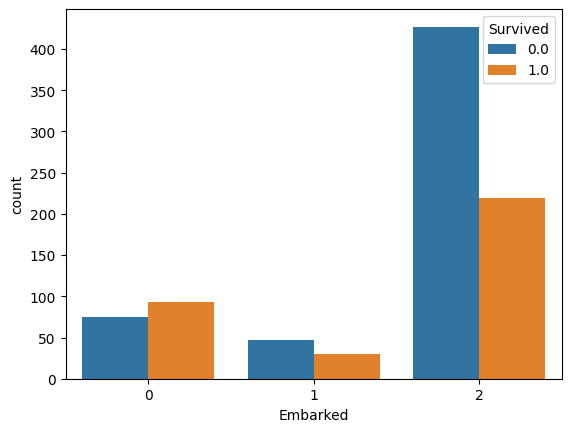

In [ ]:
#處理Embarked欄位，將每個港口的登船人數用記數圖畫出來
a = sns.countplot(x="Embarked",hue="Survived" ,data=data)
#將遺失的資料用最多填補起來
data["Embarked"] = data["Embarked"].fillna("S")
#將各個港口轉換成0，1，2
data["Embarked"] = data["Embarked"].astype("category").cat.codes

In [ ]:
print(data["Sex"].unique())
#將性別轉換成0，1
data["Sex"] = data["Sex"].astype("category").cat.codes
print(data["Sex"].unique())

['male' 'female']
[1 0]


In [ ]:
print(data["Pclass"].unique())
data["Pclass"] = data["Pclass"].astype("category").cat.codes
print(data["Pclass"].unique())

[3 1 2]
[2 0 1]


In [ ]:
#將唯一的空值用平均數補起來
data["Fare"] = data["Fare"].fillna(data["Fare"].mean())

In [ ]:
#發現Age有許多空值因此決定使用模型預測年齡
#建立一個新的data_age資料並且將Survived移除
data_age = data.drop(["Survived"],axis=1)
#依照年齡是否為空值分成訓練及測試資料集
train_age = data[data["Age"].notnull()]
test_age = data[data["Age"].isnull()]
#x為訓練的屬性
x = train_age[["Name","Sex","Pclass"]]
y = train_age["Age"]
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
#建立模型
RF = RandomForestRegressor(criterion="squared_error",n_estimators=501,random_state=42)
#使用cross validation查看模型的準確度
score = cross_val_score(RF,x,y,cv=10,scoring="neg_mean_absolute_error")
print(score)
#訓練模型
RF.fit(x,y)
#預測缺失值
age_pred = RF.predict(test_age[["Name","Sex","Pclass"]])
#將預測出來的值填入
data.loc[data["Age"].isnull(),"Age"] = age_pred
data["Age"].head(5)

[-8.28647517 -8.57036956 -9.15728129 -8.79058392 -9.47700936 -9.60783211
 -8.47543382 -7.97629026 -8.08838869 -8.62719462]


,Age
0,22.0
1,38.0
2,26.0
3,35.0
4,35.0


In [ ]:
#提取艙位的第一個英文字母
data["Cabin"] = data["Cabin"].apply(lambda x: str(x)[0] if pd.notnull(x) else x)
#將未知的艙位用U(未知)代替
data["Cabin"] = data["Cabin"].fillna("U")
print(data["Cabin"].head(5))
#將艙位轉成數字
data["Cabin"] = data["Cabin"].astype("category").cat.codes
print(data["Cabin"].head(5))

0    U
1    C
2    U
3    C
4    U
Name: Cabin, dtype: object
0    8
1    2
2    8
3    2
4    8
Name: Cabin, dtype: int8


In [ ]:
#將不需要的欄位刪除
data = data.drop(["SibSp","Parch","PassengerId","Ticket"],axis=1)

In [ ]:
#依照生存欄位是否為空值分為訓練集和測試集
x = data.iloc[:891]
y = data.iloc[891:]
xtrain=x.drop("Survived",axis=1)
ytrain=x['Survived']
xtest=y.drop("Survived", axis=1)
ytest=y['Survived']

In [ ]:
#預測乘客生存
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(criterion='gini',n_estimators=500,random_state=42,oob_score=True,min_samples_leaf=2,min_samples_split=20)
RF.fit(xtrain,ytrain)
predRF = RF.predict(xtest)
print("%.4f" % RF.oob_score_)
submit = pd.read_csv("/content/gender_submission.csv")
submit["Survived"] = predRF
submit["Survived"] = submit["Survived"].astype(int)
submit.to_csv("submit-titanic.csv",index = False)

0.8361
